In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
sd = datetime(2020, 5, 6) 
ed = datetime(2023, 5, 5)
stock1 = yf.download(tickers='PEP', start=sd, end=ed, interval="1d") # TODO: use real pairs found by Wenqi
stock2 = yf.download(tickers='MCD', start=sd, end=ed, interval="1d")
print(stock1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2020-05-06  131.580002  132.229996  130.690002  130.779999  120.251411  \
2020-05-07  131.550003  132.000000  130.119995  131.550003  120.959450   
2020-05-08  133.070007  135.160004  132.460007  134.229996  123.423668   
2020-05-11  133.429993  136.199997  133.169998  134.380005  123.561607   
2020-05-12  134.759995  136.380005  132.860001  132.940002  122.237518   
...                ...         ...         ...         ...         ...   
2023-04-28  189.899994  191.619995  189.639999  190.889999  190.889999   
2023-05-01  190.449997  192.330002  190.279999  191.679993  191.679993   
2023-05-02  191.360001  192.500000  189.750000  192.250000  192.250000   
2023-05-03  192.580002  193.250000  191.779999  

In [3]:
# filter common dates of two index
def get_common_dates(stock1, stock2):
    return sorted(list(set(stock1.index.tolist()).intersection(set(stock2.index.tolist()))))

common_dates = get_common_dates(stock1, stock2)
stock1_common, stock2_common = stock1.loc[common_dates], stock2.loc[common_dates]
len(stock1_common), len(stock2_common)

(755, 755)

## Fitting mean reverting parameters

In [4]:
# model log(stock2) = beta * log(stock1) + alpha
N = len(common_dates)
test_ratio = 0.2
price1, price2 = np.array(stock1_common['Adj Close']), np.array(stock2_common['Adj Close'])
test_size = int(N * test_ratio)
train_size = N - test_size
logprice1, logprice2 = np.log(price1[:train_size]), np.log(price2[:train_size])
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(logprice1.reshape(-1, 1), logprice2)
beta, alpha = lin_reg.coef_[0], lin_reg.intercept_
print(f"Linear regression: log(stock2) = {beta} * log(stock1) + {alpha}")

Linear regression: log(stock2) = 0.9049660922462591 * log(stock1) + 0.8973001812214303


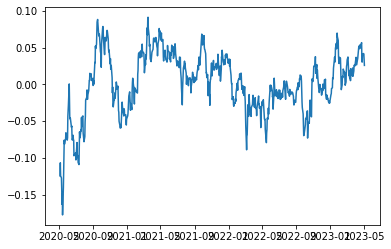

In [5]:
spread = np.log(price2) - beta * np.log(price1) - alpha
plt.plot(common_dates, spread)

## Prepare training / test data

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

def normalize_spread(data, scaler):
    scaled_data = scaler.fit_transform(data.reshape(-1,1))
    return scaled_data


def train_test_split(dates, data, test_ratio=0.2, window_size=30):
    assert len(dates) == len(data)
    test_size = int(len(dates) * test_ratio)
    train_size = len(dates) - test_size
    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(window_size, train_size):
        X_train.append(data[i - window_size:i])
        y_train.append(data[i])
    for i in range(train_size, train_size + test_size):
        X_test.append(data[i - window_size:i])
        y_test.append(data[i])
    print(f"Finishing splitting, training size: {len(X_train)}, testing size: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test, dates[:train_size], dates[train_size:]

def to_dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

scaled_spread = normalize_spread(spread, scaler)
X_train, y_train, X_test, y_test, train_dates, test_dates = train_test_split(common_dates, scaled_spread)
train_loader, test_loader = to_dataloader(X_train, y_train, X_test, y_test, batch_size=8)

Finishing splitting, training size: 574, testing size: 151


<ipython-input-6-7ebdf6c0d269>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))


## LSTM Model

In [7]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the training function
def train(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Train the model
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
train(model, train_loader, num_epochs, learning_rate)

Epoch [1/100], Step [40/72], Loss: 0.0035
Epoch [2/100], Step [40/72], Loss: 0.0012
Epoch [3/100], Step [40/72], Loss: 0.0010
Epoch [4/100], Step [40/72], Loss: 0.0009
Epoch [5/100], Step [40/72], Loss: 0.0008
Epoch [6/100], Step [40/72], Loss: 0.0008
Epoch [7/100], Step [40/72], Loss: 0.0008
Epoch [8/100], Step [40/72], Loss: 0.0008
Epoch [9/100], Step [40/72], Loss: 0.0008
Epoch [10/100], Step [40/72], Loss: 0.0007
Epoch [11/100], Step [40/72], Loss: 0.0008
Epoch [12/100], Step [40/72], Loss: 0.0009
Epoch [13/100], Step [40/72], Loss: 0.0009
Epoch [14/100], Step [40/72], Loss: 0.0009
Epoch [15/100], Step [40/72], Loss: 0.0007
Epoch [16/100], Step [40/72], Loss: 0.0005
Epoch [17/100], Step [40/72], Loss: 0.0009
Epoch [18/100], Step [40/72], Loss: 0.0017
Epoch [19/100], Step [40/72], Loss: 0.0022
Epoch [20/100], Step [40/72], Loss: 0.0024
Epoch [21/100], Step [40/72], Loss: 0.0024
Epoch [22/100], Step [40/72], Loss: 0.0024
Epoch [23/100], Step [40/72], Loss: 0.0025
Epoch [24/100], Step

Total MSE loss: 8.768543921178207e-05


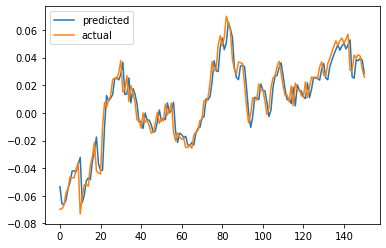

In [8]:
def test(model, test_loader):
    predictions = []
    batch_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            batch_labels.append(labels.numpy())
    return predictions, batch_labels

predictions, labels = test(model, test_loader)
predictions = scaler.inverse_transform(np.concatenate(predictions)).flatten()
labels = scaler.inverse_transform(np.concatenate(labels)).flatten()
# # # Visualize the results

plt.plot(predictions, label='predicted')
plt.plot(labels, label='actual')
print(f'Total MSE loss: {mean_squared_error(predictions, labels)}')
plt.legend()
plt.show()

## Trading Model

Suppose stock A and B are in the trade, and we modeled $$\log S_B = \beta \log S_A + \alpha$$
- Long A position: holding $1$ unit of stock A and $\beta$ unit of stock B; 
- Short A position: holding $-1$ unit of stock A and $\beta$ unit of stock B. 

Model 1 (Standard model): 
- Where $\mu$ and $\sigma$ are the statistics on the training data.
- Enter short A position when spread is over $\mu + 2\sigma$
- Enter long A position when spread is over $\mu - 2\sigma$
- Entering the position based the open price of the market

In [10]:
def simulate_standard_model(spread_pred, beta, mu, sigma, price_open_a, price_open_b, price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
        
    hold_a, hold_b = 0, 0
    invest_a, invest_b = 0, 0
    invest = 0
    histories = []
    
    # When long A, short B: consider spending money to buy A and getting money from short B at the moment
    

    num_test = len(y_test)
    for t in range(num_test):
        if spread_pred[t] < mu - 1 * sigma and invest_a != -1: # switch from long A to long B
            if invest_a == 0:
                invest_adjust = -1 + beta
            else:
                invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > mu + 1 * sigma and invest_a != 1: # switch from long B to long A
            if invest_a == 0:
                invest_adjust = 1 - beta
            else:
                invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

mu, sigma = np.mean(labels), np.std(labels)
num_train, num_test = len(y_train), len(y_test)
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
invest, histories = simulate_standard_model(predictions, beta, mu, sigma, price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)

Enter long B, short A at t=0, invest_adjustment: -0.09503390775374088
Hold A: -0.005562354025976098, hold B: 0.003414450886922891

Enter long A, short B at t=79, invest_adjustment: 0.17588761295000177
Hold A: 0.0055002475849971885, hold B: -0.003320976485307373

Final hold before clearing: (0.0055002475849971885, -0.003320976485307373)
Final investment to clear: 0.08341847327833052
--------------------
Beta: 0.9049660922462591
Final investment: -0.002564768082069624
[(0, -0.09503390775374088, 'B'), (79, 0.17588761295000177, 'A')]


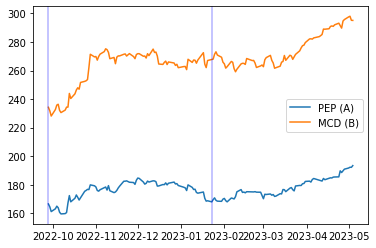

In [11]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
for t, invest_adj, long in histories:
    plt.axvline(x=test_dates[t], color='b', alpha=0.3)
plt.legend()
plt.show()

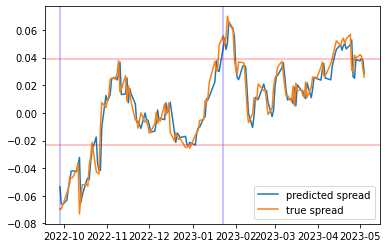

In [12]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    plt.axvline(x=test_dates[t], color='b', alpha=0.3)
plt.axhline(y=mu+sigma, color='r', alpha=0.3)
plt.axhline(y=mu-sigma, color='r', alpha=0.3)
plt.legend()
plt.show()

In [13]:
def simulate_pure_spread_signal_model(spread_cur,
                                      spread_pred,
                                      beta,
                                      alpha_a, alpha_b,
                                      price_open_a, price_open_b, 
                                      price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
        
    assert alpha_a > 0 and alpha_b > 0
    hold_a, hold_b = 0, 0
    invest_a, invest_b = 0, 0
    invest = 0
    histories = []

    num_test = len(y_test)
    for t in range(num_test):
        abs_percent_change = abs((spread_pred[t] - spread_cur[t]) / spread_cur[t])
        if spread_pred[t] < spread_cur[t] and abs_percent_change > alpha_b and invest_a != -1: # switch from long A to long B
            if invest_a == 0:
                invest_adjust = -1 + beta
            else:
                invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Signal of abs percentage change of spread: {abs_percent_change}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > spread_cur[t] and abs_percent_change > alpha_a and invest_a != 1: # switch from long B to long A
            if invest_a == 0:
                invest_adjust = 1 - beta
            else:
                invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Signal of abs percentage change of spread: {abs_percent_change}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

mu, sigma = np.mean(labels), np.std(labels)
num_train, num_test = len(y_train), len(y_test)
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
spread_test_rolled = spread[num_train+30-1:-1]
alpha_a, alpha_b = 0.2, 0.2
invest, histories = simulate_pure_spread_signal_model(spread_test_rolled, predictions, beta, alpha_a, alpha_b, 
                                            price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)

Enter long A, short B at t=23, invest_adjustment: 0.09503390775374088
Signal of abs percentage change of spread: 0.6753117982842631
Hold A: 0.005985873426397395, hold B: -0.003562858630890784

Enter long B, short A at t=39, invest_adjustment: -0.23190305527687505
Signal of abs percentage change of spread: 0.29403060398909386
Hold A: -0.006163707878092587, hold B: 0.003864733849048433

Enter long A, short B at t=43, invest_adjustment: 0.2069042983566156
Signal of abs percentage change of spread: 0.22167963218945058
Hold A: 0.005804841093626535, hold B: -0.0036817171725408867

Enter long B, short A at t=93, invest_adjustment: -0.17700498627936678
Signal of abs percentage change of spread: 1.0057107695108023
Hold A: -0.0054318303468046635, hold B: 0.003376739150172609

Final hold before clearing: (-0.0054318303468046635, 0.003376739150172609)
Final investment to clear: -0.05372903905675952
--------------------
Beta: 0.9049660922462591
Final investment: -0.05324079638912582
[(23, 0.0950339

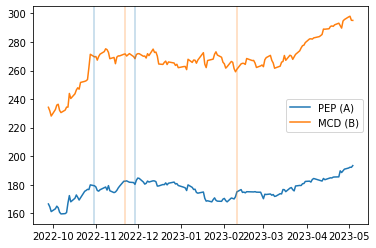

In [14]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    else:
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
plt.legend()
plt.show()

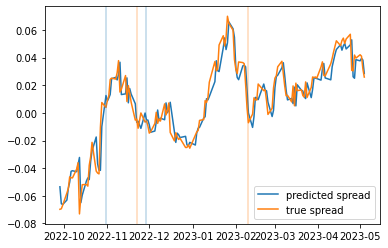

In [15]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    else:
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
plt.legend()
plt.show()